In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
from webweb import Web
import os
import seaborn as sns
from BOCC import BOCC, load_clusters
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import typing
import matplotlib.patches as mpatches
from upsetplot import from_memberships
from upsetplot import plot
import random
import pickle


std_fontsize = 12

/Users/michael/miniconda3/envs/bocc/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G22 = nx.read_edgelist('../Edgelists/String_HPO_2022.phenotypic_branch.edgelist.txt')

def remove_trivial_coms(coms):
    keepers = []
    for c in coms:
        if len(c.members) > 2 and len(c.get_genes()) > 0 and len(c.get_genes()) != len(c.members):
            keepers.append(c)
    return keepers

g_subcoms = load_clusters('../SubComs/2021/paris.greedy.2021.coms.txt')
w_subcoms = load_clusters('../SubComs/2021/paris.walktrap.2021.coms.txt')
i_subcoms = load_clusters('../SubComs/2021/paris.infomap.2021.coms.txt')
c_subcoms = load_clusters('../SubComs/2021/paris.cesna.2021.coms.txt')

In [3]:
def get_possible_pairs_from_com(coms,G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = []
    for com in coms:
        pairs.append(set())
        genes = [x for x in com.members if 'HP:' not in x]
        hpos = [x for x in com.members if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
        for g in genes:
            for h in hpos:
                p=[g,h]
                # check if p in in G
                if G.has_edge(p[0],p[1]):
                    continue
                p.sort()
                pairs[-1].add(str(p))
    return pairs

def get_possible_pairs_from_com_non_bocc(com,G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = set()
    genes = [x for x in com if 'HP:' not in x]
    hpos = [x for x in com if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
    for g in genes:
        for h in hpos:
            p=[g,h]
            # check if p in in G
            if G.has_edge(p[0],p[1]):
                continue
            p.sort()
            pairs.add(str(p))
    return pairs

def load_new_edges(el,G):
    pairs = set()
    for line in open(el,'r'):
        row = line.strip().split('\t')
        row.sort()
        if G.has_edge(row[0],row[1]):
            continue
        pairs.add(str(row))
    return pairs

# load new edges but shuffle them
def load_new_edges_shuffled(el, seed=None):
    pairs = set()
    genes = []
    hpos = []
    rows = 0
    for line in open(el,'r'):
        row = line.strip().split('\t')
        # add the HPO term to the list of HPO terms
        if 'HP:' in row[0]:
            hpos.append(row[0])
            genes.append(row[1])
        else:
            genes.append(row[0])
            hpos.append(row[1])
        rows += 1
    # shuffle the genes and hpos
    np.random.seed(seed)
    np.random.shuffle(genes)
    np.random.shuffle(hpos)
    # create the pairs
    for i in range(len(genes)):
        p = [genes[i],hpos[i]]
        p.sort()
        pairs.add(str(p))
    return pairs
    

def rediscover(pairs, el_pairs):
    # find the intersection
    results = []
    for com_pairs in pairs:
        results.append(len(com_pairs.intersection(el_pairs)))
    return results

In [ ]:
s0 = load_new_edges_shuffled(el='../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt',seed=0)
s1 = load_new_edges_shuffled(el='../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt',seed=1)

In [4]:
# get the possible pairs
g_pairs = get_possible_pairs_from_com(g_subcoms,G19)
print('Greedy',len(g_pairs))

# load the new edges
el_pairs = load_new_edges(el='../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt', G=G19)
print('2020',len(el_pairs))

# score the cluster's rediscoveries
rediscoveries = rediscover(g_pairs, el_pairs)
print('Greedy',len(rediscoveries))

# do 10 shuffled rediscoveries
shuffled_rediscoveries = []
for i in range(1000):
    s = load_new_edges_shuffled(el='../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt',seed=i)
    shuffled_rediscoveries.append(rediscover(g_pairs, s))

# compare the rediscoveries to the shuffled rediscoveries
p_values = []
for i in range(len(rediscoveries)):
    print('Cluster',i)
    this_coms_shuffled_rediscoveries = [x[i] for x in shuffled_rediscoveries]
    # empirical p-value for number of times rediscovery is greater than or equal to the shuffled rediscovery
    p = 1 - (sum([1 for x in this_coms_shuffled_rediscoveries if rediscoveries[i] >= x])/len(this_coms_shuffled_rediscoveries))
    p_values.append(p)

Greedy 1218
2020 130314
Greedy 1218
Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
Cluster 7
Cluster 8
Cluster 9
Cluster 10
Cluster 11
Cluster 12
Cluster 13
Cluster 14
Cluster 15
Cluster 16
Cluster 17
Cluster 18
Cluster 19
Cluster 20
Cluster 21
Cluster 22
Cluster 23
Cluster 24
Cluster 25
Cluster 26
Cluster 27
Cluster 28
Cluster 29
Cluster 30
Cluster 31
Cluster 32
Cluster 33
Cluster 34
Cluster 35
Cluster 36
Cluster 37
Cluster 38
Cluster 39
Cluster 40
Cluster 41
Cluster 42
Cluster 43
Cluster 44
Cluster 45
Cluster 46
Cluster 47
Cluster 48
Cluster 49
Cluster 50
Cluster 51
Cluster 52
Cluster 53
Cluster 54
Cluster 55
Cluster 56
Cluster 57
Cluster 58
Cluster 59
Cluster 60
Cluster 61
Cluster 62
Cluster 63
Cluster 64
Cluster 65
Cluster 66
Cluster 67
Cluster 68
Cluster 69
Cluster 70
Cluster 71
Cluster 72
Cluster 73
Cluster 74
Cluster 75
Cluster 76
Cluster 77
Cluster 78
Cluster 79
Cluster 80
Cluster 81
Cluster 82
Cluster 83
Cluster 84
Cluster 85
Cluster 86
Cluster 87
Cluste

Cluster 705
Cluster 706
Cluster 707
Cluster 708
Cluster 709
Cluster 710
Cluster 711
Cluster 712
Cluster 713
Cluster 714
Cluster 715
Cluster 716
Cluster 717
Cluster 718
Cluster 719
Cluster 720
Cluster 721
Cluster 722
Cluster 723
Cluster 724
Cluster 725
Cluster 726
Cluster 727
Cluster 728
Cluster 729
Cluster 730
Cluster 731
Cluster 732
Cluster 733
Cluster 734
Cluster 735
Cluster 736
Cluster 737
Cluster 738
Cluster 739
Cluster 740
Cluster 741
Cluster 742
Cluster 743
Cluster 744
Cluster 745
Cluster 746
Cluster 747
Cluster 748
Cluster 749
Cluster 750
Cluster 751
Cluster 752
Cluster 753
Cluster 754
Cluster 755
Cluster 756
Cluster 757
Cluster 758
Cluster 759
Cluster 760
Cluster 761
Cluster 762
Cluster 763
Cluster 764
Cluster 765
Cluster 766
Cluster 767
Cluster 768
Cluster 769
Cluster 770
Cluster 771
Cluster 772
Cluster 773
Cluster 774
Cluster 775
Cluster 776
Cluster 777
Cluster 778
Cluster 779
Cluster 780
Cluster 781
Cluster 782
Cluster 783
Cluster 784
Cluster 785
Cluster 786
Cluster 787
Clus

In [84]:
print(rediscoveries)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 6, 9, 119, 1, 3, 1, 17, 8, 54, 83, 28, 5, 18, 7, 0, 9, 5, 2, 136, 11, 114, 27, 24, 40, 0, 4, 17, 16, 1, 5, 40, 5, 1, 0, 41, 36, 0, 0, 1, 15, 2, 5, 0, 9, 10, 12, 8, 3, 9, 6, 126, 7, 0, 0, 16, 4, 19, 11, 4, 8, 17, 2, 1, 5, 3, 0, 0, 12, 0, 13, 0, 0, 0, 0, 0, 10, 4, 0, 7, 0, 14, 0, 29, 0, 5, 0, 0, 5, 0, 0, 7, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 13, 4, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 1, 0, 1, 0, 0, 17, 58, 0, 43, 0, 0, 0, 0, 8, 0, 20, 2, 1, 0, 0, 0, 2, 1, 0, 0, 2, 0, 27, 21, 370, 0, 2, 56, 0, 4, 1, 0, 5, 8, 0,

In [ ]:
# plot a histogram of the p-values
plt.hist(p_values,bins=100)
plt.xlabel('p-value')
plt.ylabel('Count')
plt.title('Greedy')
plt.yscale('log')
plt.savefig('Greedy.png',dpi=300)


In [9]:
cluster_scores = {}
first= True
for line in open('../AnyNewEdgeCountSnowballedCleanedSplit100BOCCResultsCombinedFixed/2021/paris.greedy.2021.bocc_res.tsv','r'):
    row = line.strip().split('\t')
    if first:
        first = False
        print(row[35])
        continue
#     print(line)
    cluster_scores['paris.greedy.2021:{}'.format(row[0])] = float(row[35])
print(list(cluster_scores.keys())[0])

sub_com_names = ['paris.greedy.2021:{}'.format(x.name) for x in g_subcoms]
print(sub_com_names)

snowballing_pvalue
paris.greedy.2021:42
['paris.greedy.2021:0', 'paris.greedy.2021:1', 'paris.greedy.2021:2', 'paris.greedy.2021:3', 'paris.greedy.2021:4', 'paris.greedy.2021:5', 'paris.greedy.2021:6', 'paris.greedy.2021:7', 'paris.greedy.2021:8', 'paris.greedy.2021:9', 'paris.greedy.2021:10', 'paris.greedy.2021:11', 'paris.greedy.2021:12', 'paris.greedy.2021:13', 'paris.greedy.2021:14', 'paris.greedy.2021:15', 'paris.greedy.2021:16', 'paris.greedy.2021:17', 'paris.greedy.2021:18', 'paris.greedy.2021:19', 'paris.greedy.2021:20', 'paris.greedy.2021:21', 'paris.greedy.2021:22', 'paris.greedy.2021:23', 'paris.greedy.2021:24', 'paris.greedy.2021:25', 'paris.greedy.2021:26', 'paris.greedy.2021:27', 'paris.greedy.2021:28', 'paris.greedy.2021:29', 'paris.greedy.2021:30', 'paris.greedy.2021:31', 'paris.greedy.2021:32', 'paris.greedy.2021:33', 'paris.greedy.2021:34', 'paris.greedy.2021:35', 'paris.greedy.2021:36', 'paris.greedy.2021:37', 'paris.greedy.2021:38', 'paris.greedy.2021:39', 'paris.gr

336
3
379


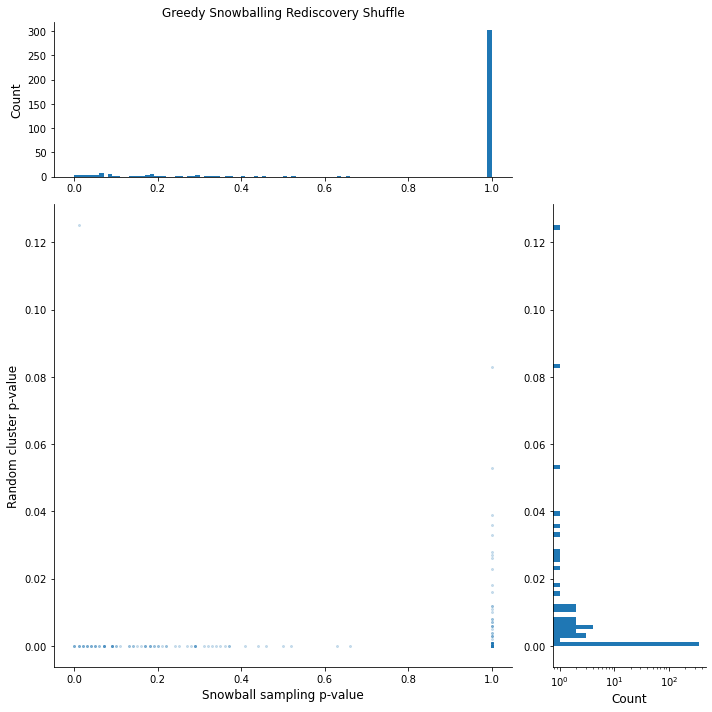

In [20]:
# sub set p valuesa and sub com names to only include those that are in the cluster_scores dictionary
p_values_filtered = []
sub_com_names_filtered = []
for i in range(len(p_values)):
    if sub_com_names[i] in cluster_scores:
        p_values_filtered.append(p_values[i])
        sub_com_names_filtered.append(sub_com_names[i])
# make a dataframe of the p-values and cluster scores and cluster names
df = pd.DataFrame({'p-value':p_values_filtered,'cluster_score': [cluster_scores[x] for x in sub_com_names_filtered],'cluster_name':sub_com_names_filtered})

# plot the p-values vs the cluster scores
# plt.scatter(df['cluster_score'],df['p-value'],s=4,alpha=.2)
# plt.xlabel('Cluster Score')
# plt.ylabel('p-value')
# plt.title('Greedy')
# plt.savefig('greedy.scatter.png',dpi=300)

# make the same scatter plot but plot density on axers above and to the right of it
# fig, ax = plt.subplots(2,2)
# same as the line above but with width and height ratios
fig, ax = plt.subplots(2,2,gridspec_kw={'width_ratios':[3,1],'height_ratios':[1,3]})
fig.set_size_inches(10,10)
ax[1,0].scatter(df['cluster_score'],df['p-value'],s=4,alpha=.2)
ax[0,0].hist(df['cluster_score'],bins=100)
ax[1,1].hist(df['p-value'],bins=100,orientation='horizontal')
# ax[0,1].set_yscale('log')
# ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('Snowball sampling p-value',fontsize=std_fontsize)
ax[1,0].set_ylabel('Random cluster p-value',fontsize=std_fontsize)
ax[0,0].set_ylabel('Count',fontsize=std_fontsize)
ax[1,1].set_xlabel('Count',fontsize=std_fontsize)
ax[1,1].set_xscale('log')
ax[0,1].set_visible(False)
# remove top and right spines
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,0].set_title('Greedy Snowballing Rediscovery Shuffle')
plt.tight_layout()
plt.savefig('../PublicationFigures/greedy.snowball_v_edge_shuffle.scatter.density.png',dpi=300)

print(sum(df['p-value'] == 0) )
print(sum(df['cluster_score'] == 0) )
print(df.shape[0])



# Random Clusters


In [ ]:
# for each cluster, get the number of members
random.seed(0)
# check if cluster_rediscoveries.pickle exists
if os.path.exists('cluster_rediscoveries.pickle'):
    # load the pickle file
    with open('cluster_rediscoveries.pickle','rb') as f:
        cluster_rediscoveries = pickle.load(f)
else:
    cluster_rediscoveries = []
    for j in range(1000):
        if j % 100 == 0:
            print(j)
        cluster_rediscoveries.append([])
        for i in range(len(g_subcoms)):
            # print('Cluster',i)
            first_resample = True
            # print(i)
            size = len(g_subcoms[i].members)
            if size < 3:
                cluster_rediscoveries[-1].append(rediscoveries)
                continue
            # from G19 pick size number of nodes at random, if there nodes do not have a phenotype, then re pick
            heterozygous = False
            while not heterozygous:
                # the line above but make sure it samples without replacement
                nodes = random.choices(list(G19.nodes),k=size)
                has_hpo = any([ 'HP:' in x for x in nodes])
                has_gene = any([ 'HP:' not in x for x in nodes])
                heterozygous = has_hpo and has_gene
            random_pairs = get_possible_pairs_from_com_non_bocc(nodes, G19)
            rediscoveries = len(random_pairs.intersection(el_pairs))
            cluster_rediscoveries[j].append(rediscoveries)

    for i in range(len(cluster_rediscoveries)):
        print(i, len(cluster_rediscoveries[i]))
    with open('cluster_rediscoveries.pickle','wb') as f:
        pickle.dump(cluster_rediscoveries,f)

In [6]:
# pickle cluster_rediscoveries

with open('cluster_rediscoveries.pickle','rb') as f:
        cluster_rediscoveries = pickle.load(f)
# make pvalues of cluster_rediscoveries vs rediscoveries
rediscovery_p_values = []
for i in range(len(rediscoveries)):
    this_coms_cluster_rediscoveries = [x[i] for x in cluster_rediscoveries]
    # empirical p-value for number of times rediscovery is greater than or equal to the shuffled rediscovery
    p = 1 - (sum([1 for x in this_coms_cluster_rediscoveries if rediscoveries[i] >= x])/len(this_coms_cluster_rediscoveries))
    rediscovery_p_values.append(p)



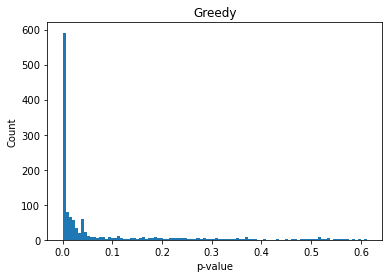

In [86]:
# histogram of rediscovery p-values
plt.hist(rediscovery_p_values,bins=100)
plt.xlabel('p-value')
plt.ylabel('Count')
plt.title('Greedy')
plt.savefig('greedy.random_coms_p_values.hist.png',dpi=300)


In [ ]:
# filter rediscovery_p_values and sub_com_names to be only those that have a cluster score
sub_com_names = ['paris.greedy.2021:{}'.format(x.name) for x in g_subcoms]

p_values_filtered_random_null = []
sub_com_names_filtered_random_null = []
for i in range(len(rediscovery_p_values)):
    if sub_com_names[i] in cluster_scores:
        p_values_filtered_random_null.append(rediscovery_p_values[i])
        sub_com_names_filtered_random_null.append(sub_com_names[i])
# make a dataframe of the rediscovery p-values and cluster scores and cluster names
random_null_df = pd.DataFrame({'p-value':p_values_filtered_random_null,'cluster_score': [cluster_scores[x] for x in sub_com_names_filtered_random_null],'cluster_name':sub_com_names_filtered_random_null})


3
213
0.0
0.0


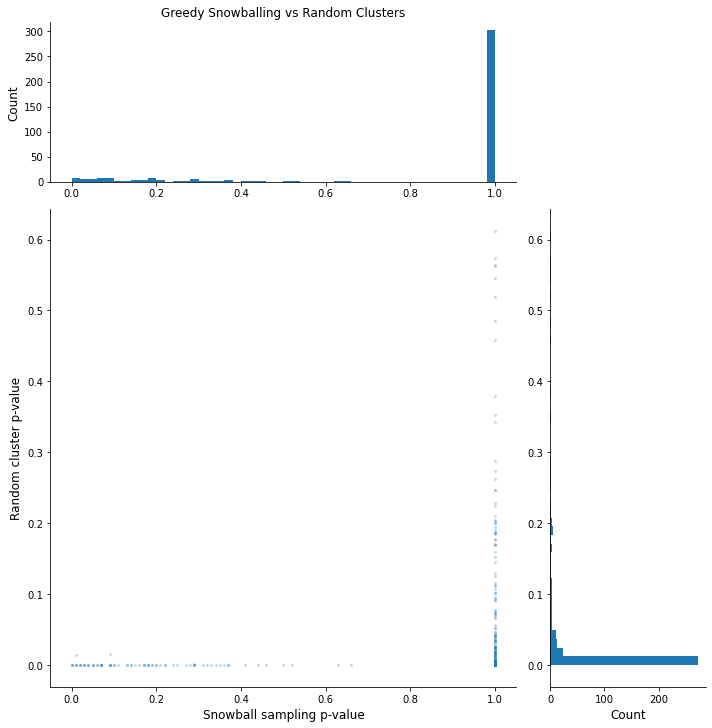

In [13]:
# 4 panel plot, top left is histogram of cluster scores, bottom right is histogram of p-values, bottom left is scatter plot of cluster scores vs p-values, top right is empty
fig, ax = plt.subplots(2,2,gridspec_kw={'width_ratios':[3,1],'height_ratios':[1,3]})
fig.set_size_inches(10,10)
ax[1,0].scatter(random_null_df['cluster_score'],random_null_df['p-value'],s=4,alpha=.2)
ax[0,0].hist(random_null_df['cluster_score'],bins=50)
ax[1,1].hist(random_null_df['p-value'],bins=50,orientation='horizontal')
# ax[0,1].set_yscale('log')
# ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('Snowball sampling p-value',fontsize=std_fontsize)
ax[1,0].set_ylabel('Random cluster p-value',fontsize=std_fontsize)
ax[0,0].set_ylabel('Count',fontsize=std_fontsize) 
ax[1,1].set_xlabel('Count',fontsize=std_fontsize)
# ax[1,1].set_xscale('log')
ax[0,1].set_visible(False)
# remove top and right spines
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
plt.tight_layout()
ax[0,0].set_title('Greedy Snowballing vs Random Clusters')
plt.savefig('../PublicationFigures/greedy.random_null.scatter.density.png',dpi=300)

# count the number of p == 0.0001 in cluster scores
print(sum([1 for x in random_null_df['cluster_score'] if x == 0]))
# count the number of p == 0.0001 in pvalue
print(sum([1 for x in random_null_df['p-value'] if x == 0]))
print(min(random_null_df['p-value']))
print(min(random_null_df['cluster_score']))